In [ ]:
! git clone https://github.com/iceysiyiai/VisualFeatureSearch.git

In [1]:
import torch
from torchvision import transforms, utils

IMAGENET_MU = [0.485, 0.456, 0.406]
IMAGENET_SIGMA = [0.229, 0.224, 0.225]


class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super(NormalizeInverse, self).__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super(NormalizeInverse, self).__call__(tensor.clone())


class Clip(object):
    """Pytorch transformation that clips a tensor to be within [0,1]"""
    def __init__(self):
        return

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): tensor to be clipped.
        Returns:
            Tensor: clipped tensor.
        """
        t = tensor.clone()
        t[t > 1] = 1
        t[t < 0] = 0
        return t
def get_detransform(mu=IMAGENET_MU, sigma=IMAGENET_SIGMA):
    detransform = transforms.Compose([
        NormalizeInverse(mu, sigma),
        Clip(),
        # transforms.ToPILImage(),
    ])
    return detransform

detransform = get_detransform()

In [2]:
import matplotlib
import matplotlib.pyplot as plt

def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

137
Image name and label: ILSVRC2012_val_00000138.JPEG 328
Image name: ILSVRC2012_val_00000138.JPEG
Image label:328
val_250/val_250/ILSVRC2012_val_00000138.JPEG
Image classification:  'sea urchin'
Image label:328


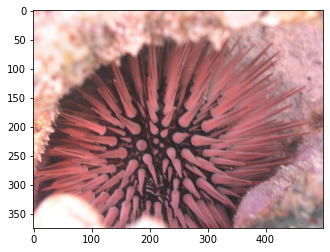

Image type: torch.FloatTensor
Image size: torch.Size([3, 375, 500])


In [3]:
import pandas as pd
import random
from PIL import Image

# Function to load random image

def load_random_image():
    # Generate random image
    n = random.randint(0, 250)
    print('Random number generated: '+ n)
    # Read from data set, split path and label
    dataset250 = pd.read_csv('val_250/path_lable.txt', sep = '/', header = None, names = ["path", "label"])
    img_name_label = dataset250.iloc[n, 1]
    path, label_str = img_name_label.split()
    label = int(label_str)
    # Print path and label
    print('Image path: {}'.format(path))
    print('Image label:{}'.format(label))
    
    
    




lable_name = pd.read_csv('val_250/lables.txt', sep = ':')
class_names = []
for i in range(1000):
  class_names.append(lable_name.iloc[i-1, 1].rstrip(","))

print('Image classification: {}'.format(class_names[label]))
print('Image label:{}'.format(label))

# function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file.
image = Image.open(img_path)
rgb_image = pil2tensor(image)

plot_image(rgb_image)


In [6]:
import sys, os
sys.path.append('./VisualFeatureSearch')
from vissearch import widgets, util, data
convert_tensor = transforms.ToTensor()
import numpy as np
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import mod


size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # (x - mean) / std
])

# x = convert_tensor(image)

x = transform(image)

query_vis_transform = transforms.Compose([
    transforms.CenterCrop((256,256)),
    transforms.Resize((224,224))
])

query_model_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# query_imgs = [load_img(id) for id in query_img_ids]
query_img = query_vis_transform(image)
# convert images to Data URLs so we can pass them into the HTML widget
query_img_url = util.image_to_durl(query_img)

# print(query_img_url)
highlight_data = None


def highlight_callback(data):
    global highlight_data 
    highlight_data = data
    mask = util.durl_to_image(data)
    mask_arr = np.asarray(mask)[:,:,3] / 256 # take just the alpha channel

    curr_mask_overlay = util.mask_overlay(query_img, x=0, y=0, mask_size=224, mask=mask_arr, alpha=0.5, beta=0.4)

    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    model.eval()

    img_input = img_transform(query_img)
    mask_input = mask_transform(mask_arr)
    data_out = score_gen(mod.transform_Gaussian, img_input, mask_input, model)
    return data_out
    # Thinking: need some other functino here to refer back to the html
    
    
    
    
util.create_callback('highlight_callback', highlight_callback)
widgets.HighlightWidget(query_img_url, callback_name='highlight_callback')




In [ ]:
def score_gen (transform, img_input, mask_input, model):

  masked_img = transform(img_input, mask_input)
  plot_image(masked_img)

  # put through model
  with torch.no_grad():
    y_output = model(masked_img.unsqueeze(0))
  
  softmax = nn.Softmax()
  y_softmax = softmax(y_output)
  k = 5

  confidences = np.squeeze(y_output)
  inds = np.argsort(-confidences)
  top_k = inds[:k]
  data_csv = []

  for i, ind in enumerate(top_k):
    data_csv.append([class_names[ind], 100*y_softmax[0,ind].item()])
    print(f'Class #{i + 1} - {class_names[ind]} - Logit: {y_output[0,ind]:.2f} - Softmax: {100*y_softmax[0,ind]:.2f}%')
  return data_csv

In [ ]:
import os

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model.eval()

img_input = img_transform(query_img)
mask_input = mask_transform(mask_arr)
data_out = score_gen(transform_Gaussian, img_input, mask_input, model)
print (data_out)
df = pd.DataFrame(data_out, columns=['Class', 'Confidence'])
print(df)
os.makedirs('Documents/GitHub', exist_ok=True)  
df.to_csv('Documents/GitHub/out.csv')  

#ploting the chart non-interactively
X = list(df.iloc[:, 0])
Y = list(df.iloc[:, 1])
  
# Plot the data using bar() method
plt.barh(X, Y, color='b')
plt.title("Results")
plt.xlabel("Class")
plt.ylabel("Confidence")
  
# Show the plot
plt.show()

In [ ]:
! git clone https://github.com/pytorch/serve
! cp serve/examples/image_classifier/kitten.jpg .
! cp serve/examples/image_classifier/index_to_name.json .

In [ ]:
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request

In [ ]:
! pip install flask